Essa análise econômica é fictícia e será realizada com todos os custos

In [49]:
# Importa e instala as seguintes bibliotecas
!pip install numpy-financial
!pip install matplotlib
import numpy_financial as npf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Defina suas variáveis
Qi = 120  # Valor exemplo
De = 0.09  # Taxa de declínio exponencial (9%/ano)

# Crie um DataFrame com anos de 2024 a 2047
df = pd.DataFrame({
    'Ano': range(2024, 2048)
})

# Atribua valores para a coluna 'N' com base nos números de poços em cada ano
df['N'] = [1, 1, 5, 8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 0]

# Crie uma função para calcular a produção com base no número de poços e no valor inicial
def calcular_producao(row):
    if row['Ano'] == 2024:
        return 0
    N = row['N']
    return Qi * (1 - De) ** (row['Ano'] - 2025) * N

df['Producao anual (bbl/d)'] = df.apply(calcular_producao, axis=1)

# Aplique a função para calcular a produção e adicione uma coluna 'Producao' ao DataFrame
df['Producao anual (bbl/d)'] = df.apply(calcular_producao, axis=1)

# Corrijo a lista Bc para ter 24 elementos, alinhado com o DataFrame
Bc = [90, 85, 85, 75, 75, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65]

# Adicione a coluna do preço do barril ao DataFrame
df['Bc (U$)'] = Bc  # Esse é a previsão do valor do barril de petróleo BRENT

# Mostre o DataFrame resultante
print(df)

     Ano   N  Producao anual (bbl/d)  Bc (U$)
0   2024   1                0.000000       90
1   2025   1              120.000000       85
2   2026   5              546.000000       85
3   2027   8              794.976000       75
4   2028  12             1085.142240       75
5   2029  12              987.479438       65
6   2030  12              898.606289       65
7   2031  12              817.731723       65
8   2032  12              744.135868       65
9   2033  12              677.163640       65
10  2034  12              616.218912       65
11  2035  12              560.759210       65
12  2036  12              510.290881       65
13  2037  12              464.364702       65
14  2038  12              422.571879       65
15  2039  12              384.540410       65
16  2040  12              349.931773       65
17  2041  12              318.437913       65
18  2042  12              289.778501       65
19  2043  12              263.698436       65
20  2044  12              239.9655

In [50]:
# Agora vamos criar a receita bruta
import calendar

# Primeiro crie uma coluna com números de dias de cada ano, porque isso irá variar
df['Dias'] = df['Ano'].apply(lambda x: 366 if calendar.isleap(x) else 365)

#Cria os valores dos CAPEX
Capex_poço = 2000000 #Em dólares #nesse caso para simplificação estou colocando todos os custos implicados no poço, como licença ambiental, perfuração, completação e etc.,
             #poderia separar esses custos para avaliar o impacto de cada um deles na análise econômica, mas já adianto que não tem muito impacto
Capex_instalacoes_superficie = 10000  #Em doláres #Esses custos devem ser utilizados de projetos análogos. Em prospectos não vale a pena ficar separando esses custos, não faz muito sentido
                                      #discutir preços de parafusos se nem sabe se tem óleo embaixo

# Cálculo do CAPEX de Poço
# Primeiro, calcula o CAPEX para o primeiro poço sem considerar a diferença
df.loc[df.index[0], 'CAPEX Poço U$'] = df.loc[df.index[0], 'N'] * Capex_poço

# Em seguida, para os anos subsequentes, aplica a regra de diferença
for i in range(1, len(df)):
    diff = df.loc[df.index[i], 'N'] - df.loc[df.index[i-1], 'N']
    df.loc[df.index[i], 'CAPEX Poço U$'] = max(diff, 0) * Capex_poço

# Cálculo do CAPEX Instalações de superfície #Poderia se adicionar outros custos, como aquisição do bloco
df['CAPEX Instalações de superfície (U$)'] = 0
df.loc[df.index[0], 'CAPEX Instalações de superfície (U$)'] = Capex_instalacoes_superficie

# Inicialize a coluna "Capex abandono ($)" com valores 0
df['Capex abandono poços (U$)'] = 0
# Calcule o "Capex abandono ($)" para o último ano
df.loc[df.index[-1], 'Capex abandono poços (U$)'] = 200000 * df.loc[df.index[-2], 'N']

# Inicialize a coluna "Capex abandono instalações superfície ($)" com valores 0
df['Capex abandono instalações superfície (U$)'] = 0
# Calcule o "Capex abandono instalações superfície" para o último ano
df.loc[df.index[-1], 'Capex abandono instalações superfície (U$)'] = 1000000

# Para calcular a receita bruta vamos supor que o nosso óleo a ser produzido é um pouco pior que o BRENT, então os contratos de venda terão um deságio de 5 doláres. Aqui poderia ser feito um deságio em % tambem, depende
# de como você acha melhor
db = 5 #deságio do BRENT em dólares
# Crie uma função para calcular a receita bruta
def receita_bruta(row):
    producao = row['Producao anual (bbl/d)']
    Bc = row['Bc (U$)']
    Dias = row['Dias']
    return producao * (Bc - db) * Dias

# Aplique a função para calcular a receita bruta e adicione uma coluna 'Receita Bruta' ao DataFrame
df['Receita Bruta (U$)'] = df.apply(receita_bruta, axis=1)
df.head()


,Ano,N,Producao anual (bbl/d),Bc (U$),Dias,CAPEX Poço U$,CAPEX Instalações de superfície (U$),Capex abandono poços (U$),Capex abandono instalações superfície (U$),Receita Bruta (U$)
0,2024,1,0.00000,90,366,2000000.0,10000,0,0,0.000000e+00
1,2025,1,120.00000,85,365,0.0,0,0,0,3.504000e+06
2,2026,5,546.00000,85,365,8000000.0,0,0,0,1.594320e+07
3,2027,8,794.97600,75,365,6000000.0,0,0,0,2.031164e+07
4,2028,12,1085.14224,75,366,8000000.0,0,0,0,2.780134e+07


In [51]:
#Agora vamos colocar algumas taxas e impostos referentes ao Brasil, cada pais deve ter sua variação
# Crie uma função para calcular a produção com base no número de poços e no valor inicial
def calcular_PIS_CONFIS (row):
    rb = row['Receita Bruta (U$)']
    return 0.0925 * rb

# Aplique a função para calcular a produção e adicione uma coluna 'Producao' ao DataFrame
df['PIS_CONFIS (U$)'] = df.apply(calcular_PIS_CONFIS, axis=1)

df.head()

#Em cima da receita bruta ainda tem o Royalties e a taxa para o superficiário
def calcular_taxa_superficirio (row):
    rb = row['Receita Bruta (U$)']
    return 0.01 * rb #a taxa pode varia de 0,5 a 1%, mas normalmente se paga 1%

# defina a equação do cálculo da taxa do superficiário
df['Superficiário (U$)'] = df.apply(calcular_taxa_superficirio, axis=1)

#defina a equação do cálculo do royalties
def royalties (row):
    rb = row['Receita Bruta (U$)']
    return 0.075 * rb  # Dependendo do tipo da empresa e do empreendimento pode ser menor

# Aplique a função para calcular a produção e adicione uma coluna 'Producao' ao DataFrame
df['Royalties (U$)'] = df.apply(calcular_taxa_superficirio, axis=1)

df.head()

,Ano,N,Producao anual (bbl/d),Bc (U$),Dias,CAPEX Poço U$,CAPEX Instalações de superfície (U$),Capex abandono poços (U$),Capex abandono instalações superfície (U$),Receita Bruta (U$),PIS_CONFIS (U$),Superficiário (U$),Royalties (U$)
0,2024,1,0.00000,90,366,2000000.0,10000,0,0,0.000000e+00,0.000000e+00,0.000000,0.000000
1,2025,1,120.00000,85,365,0.0,0,0,0,3.504000e+06,3.241200e+05,35040.000000,35040.000000
2,2026,5,546.00000,85,365,8000000.0,0,0,0,1.594320e+07,1.474746e+06,159432.000000,159432.000000
3,2027,8,794.97600,75,365,6000000.0,0,0,0,2.031164e+07,1.878826e+06,203116.368000,203116.368000
4,2028,12,1085.14224,75,366,8000000.0,0,0,0,2.780134e+07,2.571624e+06,278013.441888,278013.441888


In [54]:
#Próximo passo é calcular as depesas fixas/mensais. Para simplificação aqui, considerará um custo médio de produção, chamado Lifting cost. As empresas e companhia SA tem que pulicar seus balanços e com isso é possível
#ver o lifting cost delas. Aqui adotaremos a média de 23 bbl/d, um número comum entre as operadoras onshore
lc = 23 #U$/bbl
# Crie uma função para calcular a receita bruta
def lifting_cost (row):
    producao = row['Producao anual (bbl/d)']
    Dias = row['Dias']
    return producao * lc * Dias
    # Aplique a função para calcular a receita bruta e adicione uma coluna 'Receita Bruta' ao DataFrame
df['Custo de producao (U$)'] = df.apply(lifting_cost, axis=1)
df.head()

,Ano,N,Producao anual (bbl/d),Bc (U$),Dias,CAPEX Poço U$,CAPEX Instalações de superfície (U$),Capex abandono poços (U$),Capex abandono instalações superfície (U$),Receita Bruta (U$),PIS_CONFIS (U$),Superficiário (U$),Royalties (U$),Custo de producao (U$)
0,2024,1,0.00000,90,366,2000000.0,10000,0,0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
1,2025,1,120.00000,85,365,0.0,0,0,0,3.504000e+06,3.241200e+05,35040.000000,35040.000000,1.007400e+06
2,2026,5,546.00000,85,365,8000000.0,0,0,0,1.594320e+07,1.474746e+06,159432.000000,159432.000000,4.583670e+06
3,2027,8,794.97600,75,365,6000000.0,0,0,0,2.031164e+07,1.878826e+06,203116.368000,203116.368000,6.673824e+06
4,2028,12,1085.14224,75,366,8000000.0,0,0,0,2.780134e+07,2.571624e+06,278013.441888,278013.441888,9.134727e+06


In [55]:
# Agora vamos calcular a receita líquida e a EBITDA
# Crie uma função para calcular a receita líquida
def receita_liquida(row):
    bruta = row['Receita Bruta (U$)']
    pis_confins = row['PIS_CONFIS (U$)']
    royalties = row['Royalties (U$)']
    return bruta - pis_confins - royalties

# Aplique a função para calcular a receita bruta e adicione uma coluna 'Receita Bruta' ao DataFrame
df['Receita líquida (U$)'] = df.apply(receita_liquida, axis=1)

# Crie uma função para calcular a EBITDA
def ebitda(row):
    liquida = row['Receita líquida (U$)']
    opex = row['Custo de producao (U$)']
    return liquida - opex

# Aplique a função para calcular a receita bruta e adicione uma coluna 'Receita Bruta' ao DataFrame
df['EBITDA (U$)'] = df.apply(ebitda, axis=1)
df.head()

,Ano,N,Producao anual (bbl/d),Bc (U$),Dias,CAPEX Poço U$,CAPEX Instalações de superfície (U$),Capex abandono poços (U$),Capex abandono instalações superfície (U$),Receita Bruta (U$),PIS_CONFIS (U$),Superficiário (U$),Royalties (U$),Custo de producao (U$),Receita líquida (U$),EBITDA (U$)
0,2024,1,0.00000,90,366,2000000.0,10000,0,0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,2025,1,120.00000,85,365,0.0,0,0,0,3.504000e+06,3.241200e+05,35040.000000,35040.000000,1.007400e+06,3.144840e+06,2.137440e+06
2,2026,5,546.00000,85,365,8000000.0,0,0,0,1.594320e+07,1.474746e+06,159432.000000,159432.000000,4.583670e+06,1.430902e+07,9.725352e+06
3,2027,8,794.97600,75,365,6000000.0,0,0,0,2.031164e+07,1.878826e+06,203116.368000,203116.368000,6.673824e+06,1.822969e+07,1.155587e+07
4,2028,12,1085.14224,75,366,8000000.0,0,0,0,2.780134e+07,2.571624e+06,278013.441888,278013.441888,9.134727e+06,2.495171e+07,1.581698e+07


In [56]:
# A depreciação será feita com % das reservas, ou seja, considerou-se que ao final da produção todas reservas, as instalações perderam 100% do seu valor. Isso não é necessariamente verdade.
# várias coisas (vocabulário de geólogo para instalações de superfície) poderiam ser utilizadas, mas novamente, menos é mais em uma análise econômica de ativos exploratórios
#Vamos então calcular as reservas totais e a % de reserva que se perde em cada ano de produção
def reserva_produzida(row):
    prod = row['Producao anual (bbl/d)']
    dia = row['Dias']
    return prod * dia

df['Reserva produzida (bbl)'] = df.apply(reserva_produzida, axis=1)
df.head()




,Ano,N,Producao anual (bbl/d),Bc (U$),Dias,CAPEX Poço U$,CAPEX Instalações de superfície (U$),Capex abandono poços (U$),Capex abandono instalações superfície (U$),Receita Bruta (U$),PIS_CONFIS (U$),Superficiário (U$),Royalties (U$),Custo de producao (U$),Receita líquida (U$),EBITDA (U$),Reserva produzida (bbl)
0,2024,1,0.00000,90,366,2000000.0,10000,0,0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.00000
1,2025,1,120.00000,85,365,0.0,0,0,0,3.504000e+06,3.241200e+05,35040.000000,35040.000000,1.007400e+06,3.144840e+06,2.137440e+06,43800.00000
2,2026,5,546.00000,85,365,8000000.0,0,0,0,1.594320e+07,1.474746e+06,159432.000000,159432.000000,4.583670e+06,1.430902e+07,9.725352e+06,199290.00000
3,2027,8,794.97600,75,365,6000000.0,0,0,0,2.031164e+07,1.878826e+06,203116.368000,203116.368000,6.673824e+06,1.822969e+07,1.155587e+07,290166.24000
4,2028,12,1085.14224,75,366,8000000.0,0,0,0,2.780134e+07,2.571624e+06,278013.441888,278013.441888,9.134727e+06,2.495171e+07,1.581698e+07,397162.05984


In [57]:
total_reserva_produzida = df['Reserva produzida (bbl)'].sum()
print(total_reserva_produzida)

def reserva_prod_fracao(row):
    res_cumulativa = row['Reserva produzida cumulativa']
    return res_cumulativa / total_reserva_produzida

# Calcula a soma cumulativa da coluna 'Reserva produzida (bbl)'
df['Reserva produzida cumulativa'] = df['Reserva produzida (bbl)'].cumsum()

df['% da reserva produzida (%)'] = df.apply(reserva_prod_fracao, axis=1)

# Você pode remover a coluna 'Reserva produzida cumulativa' se não a desejar no dataframe final
df = df.drop('Reserva produzida cumulativa', axis=1)

df.head()


4203669.775756903


,Ano,N,Producao anual (bbl/d),Bc (U$),Dias,CAPEX Poço U$,CAPEX Instalações de superfície (U$),Capex abandono poços (U$),Capex abandono instalações superfície (U$),Receita Bruta (U$),PIS_CONFIS (U$),Superficiário (U$),Royalties (U$),Custo de producao (U$),Receita líquida (U$),EBITDA (U$),Reserva produzida (bbl),% da reserva produzida (%)
0,2024,1,0.00000,90,366,2000000.0,10000,0,0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,0.000000
1,2025,1,120.00000,85,365,0.0,0,0,0,3.504000e+06,3.241200e+05,35040.000000,35040.000000,1.007400e+06,3.144840e+06,2.137440e+06,43800.00000,0.010419
2,2026,5,546.00000,85,365,8000000.0,0,0,0,1.594320e+07,1.474746e+06,159432.000000,159432.000000,4.583670e+06,1.430902e+07,9.725352e+06,199290.00000,0.057828
3,2027,8,794.97600,75,365,6000000.0,0,0,0,2.031164e+07,1.878826e+06,203116.368000,203116.368000,6.673824e+06,1.822969e+07,1.155587e+07,290166.24000,0.126855
4,2028,12,1085.14224,75,366,8000000.0,0,0,0,2.780134e+07,2.571624e+06,278013.441888,278013.441888,9.134727e+06,2.495171e+07,1.581698e+07,397162.05984,0.221335


In [58]:
# Inicialize a coluna PE com zeros
df['PE'] = 0

# Para cada ano:
for i in range(len(df)):
    # Se for o primeiro ano, inicialize PE com 0 e calcule PEF com os CAPEX
    if i == 0:
        df.loc[df.index[i], 'PEF'] = df.loc[df.index[i], 'CAPEX Poço U$'] + df.loc[df.index[i], 'CAPEX Instalações de superfície (U$)']
    else:
        # Para anos subsequentes, atualize PE para ser o PEF do ano anterior
        df.loc[df.index[i], 'PE'] = df.loc[df.index[i-1], 'PEF']
        # Calcule PEF
        df.loc[df.index[i], 'PEF'] = df.loc[df.index[i], 'PE'] + df.loc[df.index[i], 'CAPEX Poço U$'] + df.loc[df.index[i], 'CAPEX Instalações de superfície (U$)']

    # Calcule a Depreciação para o ano atual
    df.loc[df.index[i], 'Depreciação ($)'] = -df.loc[df.index[i], 'PE'] * df['% da reserva produzida (%)'].loc[df.index[i]]

    # Atualize PEF subtraindo a depreciação
    df.loc[df.index[i], 'PEF'] += df.loc[df.index[i], 'Depreciação ($)']

# Crie a EBIT
df['EBIT (U$)'] = df['EBITDA (U$)'] - df['Depreciação ($)']

# Agora tem a tributação sobre o lucro
df['IR/CSLL (U$)'] = df['EBIT (U$)'].apply(lambda x: 0.34 * x if x > 0 else 0)
#Calcula o Lucro líquido
df['Lucro líquido (U$)'] = df['EBIT (U$)'] - df['IR/CSLL (U$)']
#Calcula o fluxo de caixa
df['Fluxo de Caixa (U$)'] = (df['Lucro líquido (U$)']
                        - df['CAPEX Poço U$']
                        - df['CAPEX Instalações de superfície (U$)']
                        - df['Capex abandono poços (U$)']
                        - df['Capex abandono instalações superfície (U$)']
                        + df['Depreciação ($)'])

df.head()


,Ano,N,Producao anual (bbl/d),Bc (U$),Dias,CAPEX Poço U$,CAPEX Instalações de superfície (U$),Capex abandono poços (U$),Capex abandono instalações superfície (U$),Receita Bruta (U$),...,EBITDA (U$),Reserva produzida (bbl),% da reserva produzida (%),PE,PEF,Depreciação ($),EBIT (U$),IR/CSLL (U$),Lucro líquido (U$),Fluxo de Caixa (U$)
0,2024,1,0.00000,90,366,2000000.0,10000,0,0,0.000000e+00,...,0.000000e+00,0.00000,0.000000,0.000000e+00,2.010000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.010000e+06
1,2025,1,120.00000,85,365,0.0,0,0,0,3.504000e+06,...,2.137440e+06,43800.00000,0.010419,2.010000e+06,1.989057e+06,-2.094313e+04,2.158383e+06,7.338503e+05,1.424533e+06,1.403590e+06
2,2026,5,546.00000,85,365,8000000.0,0,0,0,1.594320e+07,...,9.725352e+06,199290.00000,0.057828,1.989057e+06,9.874034e+06,-1.150233e+05,9.840375e+06,3.345728e+06,6.494648e+06,-1.620376e+06
3,2027,8,794.97600,75,365,6000000.0,0,0,0,2.031164e+07,...,1.155587e+07,290166.24000,0.126855,9.874034e+06,1.462146e+07,-1.252570e+06,1.280844e+07,4.354870e+06,8.453571e+06,1.201001e+06
4,2028,12,1085.14224,75,366,8000000.0,0,0,0,2.780134e+07,...,1.581698e+07,397162.05984,0.221335,1.462146e+07,1.938523e+07,-3.236238e+06,1.905322e+07,6.478094e+06,1.257512e+07,1.338885e+06


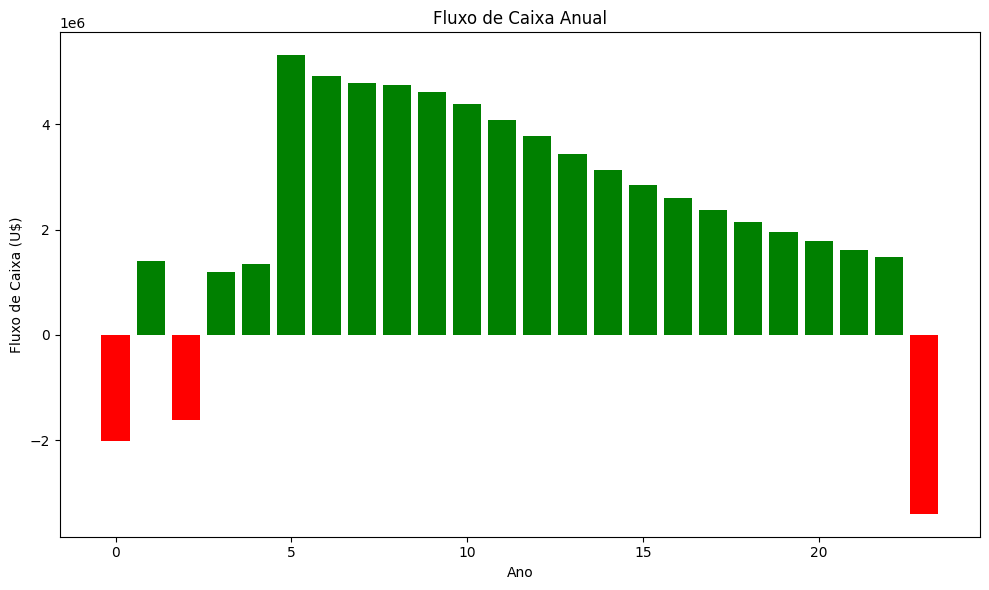

In [59]:


# Configurando o gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Criando uma lista de cores com base nos valores de 'Fluxo de Caixa (U$)'
colors = ['green' if x > 0 else 'red' for x in df['Fluxo de Caixa (U$)']]

# Criando o gráfico de barras com as cores apropriadas
ax.bar(df.index, df['Fluxo de Caixa (U$)'], color=colors)

# Adicionando título e rótulos aos eixos
ax.set_title('Fluxo de Caixa Anual')
ax.set_xlabel('Ano')
ax.set_ylabel('Fluxo de Caixa (U$)')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [60]:


def npv(rate, cash_flows):
    total_value = 0
    for i, cash_flow in enumerate(cash_flows):
        total_value += cash_flow / (1 + rate) ** i
    return total_value

# Taxa de desconto de 6% ao ano
rate = 0.06

# Calculando o VPL
cash_flows = df['Fluxo de Caixa (U$)'].values
vpl = npv(rate, cash_flows)

# Convertendo VPL para MM de USD
vpl_mm = vpl / 1e6

print(f'O Valor Presente Líquido é: ${vpl_mm:.2f} MM de USD')

# 1. Calculando a TIR
tir = npf.irr(cash_flows)
print(f'TIR: {-tir * 100:.2f}%')

# 2. Calculando o Payback
cum_cash_flows = cash_flows.cumsum()
payback_period = np.where(cum_cash_flows >= 0)[0][0] + 1  # Adicionamos 1 pois a indexação começa do 0
print(f'Payback: {payback_period} anos')

# 3. Calculando a Eficiência do Investimento
initial_investment = cash_flows[0]
vpl = npv(0.06, cash_flows)
efficiency = vpl / -initial_investment
print(f'Eficiência do Investimento: {efficiency:.2f}')

O Valor Presente Líquido é: $30.82 MM de USD
TIR: 34.70%
Payback: 5 anos
Eficiência do Investimento: 15.33


In [61]:
# Uma métrica importantíssima na exploração é o cálculo do MEV para sempre fazer as melhores decisões
taxa_de_sucesso = 0.19 #taxa de sucesso exploratório, cálculado com base nas incertezas do prospecto
taxa_de_insucesso  = 1 - taxa_de_sucesso


VME = (vpl * taxa_de_sucesso) - (Capex_poço * taxa_de_insucesso)
print(f"O valor do VME é {VME/1000000} MM U$")

O valor do VME é 4.234927223155156 MM U$
